**Semi-supervised learning with Support Vector Machines: Varying the threshold**

In semi-supervised learning,   we have a training set with some number of labeled y values, but also many without a known y value

The idea of semi-supervised learning is to create a predictor,   a SVM in this case, that is trained on the labeled data.    The predictor is then used to predict the unlabelled data.    

The best predictions among the unlabeled data (based on an estimated probability of the classification probability) are then used as labels for the next stage of model training

A threshold is used to determine which unlabeled data should be used in each iteration of the estimation.

The process is iterated as the classification improves.

The concept behind this to make use of the correlation in predictor variables to aid the learning process,  using the easily classified points in the data.


Based on
https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_self_training_varying_threshold.html#sphx-glr-auto-examples-semi-supervised-plot-self-training-varying-threshold-py

# Imports

In [1]:
# Authors: Oliver Rausch <rauscho@ethz.ch>
# License: BSD

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle


# Setting up data for semi-supervised learning
This is using the breast cancer data set

The first 50 labels are used

Labels for all other specimens (after #50) are all set to -1, which indicates a missing label

Notice that we are creating a data set specifically for semi-supervised learning, one would never delete labels in a real world application

In [2]:
# number of cross validation splits used
n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

# Add some code here

To determine the size of this data set

Also figure out the fraction that is unlabeled

**SVM Classifier**

Set up a SVM Classifier

set up a list of thresholds to use

In [4]:
base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

# x_values will be the list of probability cutoffs to use for including estimated labels

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)

#set up storage for the scores obtained for each threshold level for
# the n_splits cross validations

scores = np.empty((x_values.shape[0], n_splits))

#set up storage for the number of labels created in each cross validation split
# and the number of iterations at each threshold and split

amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))


In [5]:
# Here is the loop, which we iterate for each threshold level specified
# in the list of thresholds in x_values


for i, threshold in enumerate(x_values):

    # we specified the base classifier to use, there is now a semi-supervised
    #learning function that will run the semi-supervised learning at the
    # desired threshold

    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # We need manual cross validation so that we don't treat -1 as a separate
    # class when computing accuracy
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # The amount of labeled samples that at the end of fitting
        # so at a given threshold this tells us who many could be estimated
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        # compute the accuracy of the classifier at this threshold level
        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


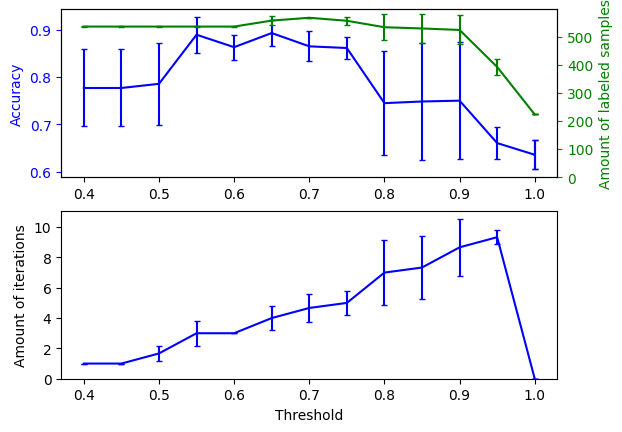

In [7]:

ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()

# Question

What threshold produced the optimal level of overall accuracy?

Why would lower or higher thresholds perform less effectively?  What do you think happens when the threshold is too low?    When it is too high?

Why do you think the number of labelled samples falls at high thresholds

Why would the number of iterations increase with the threshold?

Why would it suddenly fall when the threshold is 1?

# Question

Reload the data set and determine what the accuracy of the SVC would be using all the labeled data,  ie in a fully supervised learning setting

You will need to write (or copy and paste) some code to do this